### Import libraries

In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

# Import R32, R125, IL info file
from HFCS_hmimCl_PR import configuration

### Create model

In [2]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

2021-04-27 22:04:50 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.


In [3]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [4]:
## Update conditions to reduce DOF

# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "hmimCl"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(300)
m.fs.F101.inlet.pressure.fix(200000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(300)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [5]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

### Get flash data

In [6]:
# Set pressures to loop over
P = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000]

# Set fraction of feed compositions of HFCs to loop over
HFC_feed_frac = [0.03,0.15,0.2,0.3,0.4,0.5,0.72,0.91,0.99]

# Make outlet arrays
IL_x = np.zeros((len(P),len(HFC_feed_frac)))
IL_y = np.zeros((len(P),len(HFC_feed_frac)))
R32_x = np.zeros((len(P),len(HFC_feed_frac)))
R32_y = np.zeros((len(P),len(HFC_feed_frac)))
R125_x = np.zeros((len(P),len(HFC_feed_frac)))
R125_y = np.zeros((len(P),len(HFC_feed_frac))) 

for i in range(len(P)):
    
    # Fix pressure
    m.fs.F101.inlet.pressure.fix(P[i])
    
    for j in range(len(HFC_feed_frac)):
        
        # Fix inlet mole fractions
        fract = 1 - HFC_feed_frac[j] 
        m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.85*HFC_feed_frac[j])
        m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.85*fract)
        m.fs.F101.inlet.mole_frac_comp[0, "hmimCl"].fix(0.15)   

        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL) 
        # solve the model
        status = solver.solve(m, tee = False)
        # model.display()
        
        # If solution is optimal store the concentration, and calculated temperatures in the created arrays
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            IL_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "hmimCl"])
            IL_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "hmimCl"])
            R32_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

            #Change this to feasible
            print("Running pressure:",P[i],"and HFC feed fraction",HFC_feed_frac[j])
#             print(value(m.fs.F101.liq_outlet.flow_mol[0]))
#             print(value(m.fs.F101.vap_outlet.flow_mol[0]))
        else:
            print('Infeasible.')

Running pressure: 200000 and HFC feed fraction 0.03
Running pressure: 200000 and HFC feed fraction 0.15
Running pressure: 200000 and HFC feed fraction 0.2
Running pressure: 200000 and HFC feed fraction 0.3
Running pressure: 200000 and HFC feed fraction 0.4
Running pressure: 200000 and HFC feed fraction 0.5
Running pressure: 200000 and HFC feed fraction 0.72
Running pressure: 200000 and HFC feed fraction 0.91
Running pressure: 200000 and HFC feed fraction 0.99
Running pressure: 300000 and HFC feed fraction 0.03
Running pressure: 300000 and HFC feed fraction 0.15
Running pressure: 300000 and HFC feed fraction 0.2
Running pressure: 300000 and HFC feed fraction 0.3
Running pressure: 300000 and HFC feed fraction 0.4
Running pressure: 300000 and HFC feed fraction 0.5
Running pressure: 300000 and HFC feed fraction 0.72
Running pressure: 300000 and HFC feed fraction 0.91
Running pressure: 300000 and HFC feed fraction 0.99
Running pressure: 400000 and HFC feed fraction 0.03
Running pressure: 40

In [7]:
IL_x = IL_x*100
IL_y = IL_y*100
R32_x = R32_x*100
R32_y = R32_y*100
R125_x = R125_x*100
R125_y = R125_y*100

print("IL_x =", IL_x)
print("IL_y =", IL_y)
print("R32_x =", R32_x)
print("R32_y =", R32_y)
print("R125_x =", R125_x)
print("R125_y =", R125_y)

IL_x = [[85.78268568 86.41431202 86.67500332 87.19211973 87.70369174 88.20988504
  89.30534647 90.23229366 90.61752358]
 [79.10525467 80.05548215 80.4455324  81.21567425 81.97301537 82.71809399
  84.31652826 85.65486133 86.2074014 ]
 [72.69707105 73.97047742 74.49004002 75.51074996 76.50807191 77.48328997
  79.5565712  81.27382816 81.97810626]
 [66.54195852 68.14585913 68.79588583 70.0659081  71.29829034 72.49561276
  75.01721162 77.08283001 77.92429478]
 [60.62102549 62.56638062 63.34886283 64.86848924 66.33211729 67.74440179
  70.68968427 73.07516178 74.04031447]
 [54.91169018 57.21452334 58.13285633 59.90443445 61.59693386 63.21817028
  66.56474702 69.24380103 70.32022222]
 [49.38608149 52.06978122 53.12932826 55.15802251 57.07893362 58.90456309
  62.63270519 65.58143349 66.75780484]
 [44.00823645 47.10749287 48.31649306 50.61146034 52.76293019 54.79028116
  58.8834299  62.08047833 63.34660158]
 [38.72878601 42.29682012 43.66792734 46.24421351 48.6320414  50.86094611
  55.30636356 5

##### Store

In [8]:
points_x = []

for i in range(len(P)):
    for j in range(len(HFC_feed_frac)): #to shift how points are printed, shift the order
        points = (IL_x[i,j], R125_x[i,j], R32_x[i,j])
        points_x.append(points)

In [9]:
# points_y = []

# for i in range(len(P)):
#     for j in range(len(HFC_feed_frac)): #to shift how points are printed, shift the order
#         points = (IL_x[i,j], R125_x[i,j], R32_x[i,j])
#         points_x.append(points)

### Ternary Diagram

points 1 are: [(85.7826856820701, 13.928099591117494, 0.28921472681240634), (86.41431202225782, 12.145894651683882, 1.4397933260583093), (86.675003316979, 11.408689148785122, 1.916307534235875), (87.19211972612496, 9.943481580870916, 2.8643986930041287), (87.70369174334255, 8.49020188995187, 3.8061063667055763), (88.20988504175973, 7.048454230809639, 4.741660727430638), (89.30534647192609, 3.9153612387290733, 6.779292289344853), (90.23229365613665, 1.250072540174798, 8.517633803688542), (90.6175235831383, 0.13851317181563183, 9.243963245046066)]
points 2 are: [(79.10525466859278, 20.462013223558305, 0.43273210784891764), (80.05548214570022, 17.795790878864274, 2.148726975435498), (80.4455323971158, 16.697548133787045, 2.8569194690971766), (81.21567424884721, 14.522475610315821, 4.261850140836972), (81.97301536818277, 12.374836007789462, 5.6521486240277605), (82.71809399473926, 10.253369091477666, 7.028536913783066), (84.31652826241397, 5.672587693343089, 10.010884044242946), (85.654861

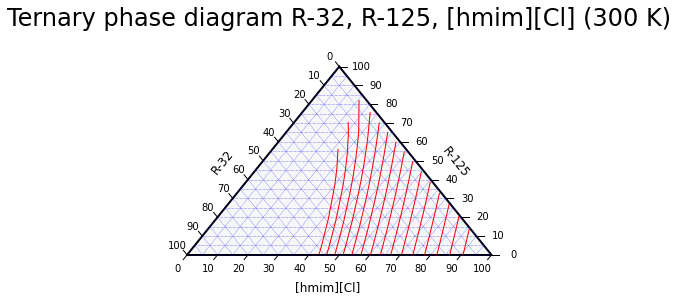

In [11]:
import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.set_title("Ternary phase diagram R-32, R-125, [hmim][Cl] (300 K)\n", fontsize=24)
tax.left_axis_label("R-32", fontsize=fontsize, offset=offset)
tax.right_axis_label("R-125", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("[hmim][Cl]", fontsize=fontsize, offset=offset)

# color_options = ['red','blue','green','black','orange','purple','teal','yellow','pink']

for i in range(len(P)):
#     color = color_options[i]
    if P[i]<=1400000:
        i = i + 1
        print("points",i,"are:",points_x[9*i-9:9*i])
        tax.plot(points_x[9*i-9:9*i], linewidth=1., color='red', linestyle="-")
    elif P[i]==1500000:
        i = i + 1
        print("points",i,"are:",points_x[9*i-9:9*i])
        tax.plot(points_x[9*i-8:9*i], linewidth=1., color='red', linestyle="-")
    else:
        i = i + 1
        print("points",i,"are:",points_x[9*i-9:9*i])
        tax.plot(points_x[9*i-6:9*i], linewidth=1., color='red', linestyle="-")

tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()